In [1]:
import os
from ordereddict import OrderedDict
os.environ['THEANO_FLAGS']="device=cpu"

from utils import tile_raster_images
from pylearn2.utils import serial
import theano
import theano.tensor as T

try:
    import PIL.Image as Image
except ImportError:
    import Image
import IPython.display as I

In [2]:
DIR_DATA = '/Users/vmisra/data/AE_experiments'
dir_model = os.path.join(DIR_DATA,'models')
dir_fuel = os.path.join(DIR_DATA,'fuel')

#Load models and data

In [3]:
test_data = serial.load(os.path.join(dir_fuel,'mnist_test_X.pkl'))

In [30]:
model_folders = [model_folder \
               for model_folder in os.listdir(dir_model) \
               if os.path.isdir(os.path.join(dir_model,model_folder))]
model_folders = ['D6','D11','D12']
submodels = []
final_models=['finetune.pkl','solotrain.pkl']

In [34]:
def get_outputs(models, submodels=[], final_models=[]):
    xhat = OrderedDict()
    for (idx,submodel) in enumerate(submodels):
        X = models[submodel].get_input_space().make_theano_batch()
        Y = X
        for jdx in range(idx+1):
            Y = models[submodels[jdx]].encode(Y)
        for jdx in range(idx+1)[::-1]:
            Y = models[submodels[jdx]].decode(Y)
        xhat[submodel] = Y.eval({X:test_data})
    for final_model in final_models:
        if final_model in models:
            X = models[final_model].get_input_space().make_theano_batch()
            Y = models[final_model].fprop(X)
            xhat[final_model] = Y.eval({X:test_data})
    return xhat

In [32]:
xhats = OrderedDict()
for model_folder in model_folders:
    print model_folder
    models = OrderedDict()
    for model_name in submodels+final_models:
        path = os.path.join(dir_model,model_folder,model_name)
        if os.path.exists(path):
            models[model_name] = serial.load(path)
    xhats[model_folder] = get_outputs(models=models, submodels=submodels, final_models=final_models)

D6
D11
D12


##visualize outputs

original


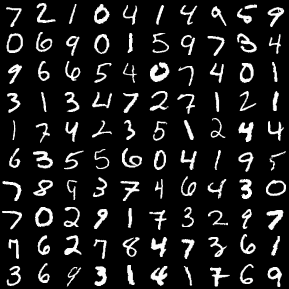

In [30]:
original_img = Image.fromarray(tile_raster_images(X=test_data,
                                                  img_shape=(28,28),
                                                  tile_shape=(10,10),
                                                  tile_spacing=(1,1)))
original_img.save('delete_me.png')
print 'original'
I.display(I.Image('delete_me.png'))

D6 solotrain.pkl


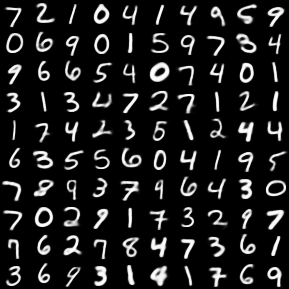

D11 solotrain.pkl


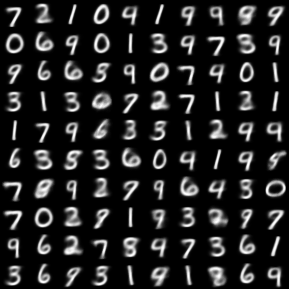

D12 solotrain.pkl


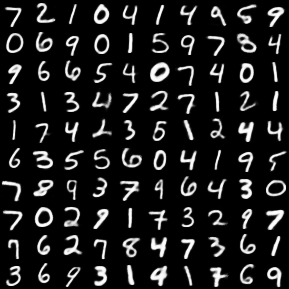

In [33]:
#model_folders = ['B17','B20']
for submodel in submodels+[final_model]: 
    for model_folder in model_folders:
        reconstructed = Image.fromarray(tile_raster_images(X=xhats[model_folder][submodel],
                                                  img_shape=(28,28),
                                                  tile_shape=(10,10),
                                                  tile_spacing=(1,1)))
        reconstructed.save('delete_me.png')
        print model_folder, submodel
        I.display(I.Image('delete_me.png'))

In [ ]:
import cPickle as pickle
params = [pickle.load(open(os.path.join(dir_model,model_folder,'params.pkl'),'r')) for model_folder in model_folders]

In [ ]:
params